<a href="https://colab.research.google.com/github/AndreiLesi/Data-Engineering/blob/master/churnAnalysis_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Spark

In [ ]:
!pip install -q pyspark

     |████████████████████████████████| 204.7MB 72kB/s 
     |████████████████████████████████| 204kB 40.1MB/s 


In [ ]:
import pyspark
import random
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder.appName("PySpark").getOrCreate()
sc = pyspark.SparkContext.getOrCreate()

# Churn Analysis

In [ ]:
import pandas as pd
from pyspark import SparkFiles
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,\
                               Imputer
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

## Load Data

In [ ]:
# Goal: Predict if a customer will churn/cancel subscription or not based on a 
# number of parameters
# Read Dataset
url = "https://raw.githubusercontent.com/treselle-systems/" + \
      "customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"

spark.sparkContext.addFile(url)

df = spark.read.option("inferSchema", True) \
    .option("header", True) \
    .option("nanValue", " ") \
    .option("nullValue", " ") \
    .csv("file://"+SparkFiles.get("WA_Fn-UseC_-Telco-Customer-Churn.csv"))

In [ ]:
# Dataframe Bassic Information
df.printSchema()
df.show(10)
display("Number of Entries: ",df.count())

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+---------

'Number of Entries: '

7043

## Analyze Data

In [ ]:
# Check if Null Values exist
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# ==> In TotalCharges, 11 Rows are None, we will replace those later on

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [ ]:
# Analyze categorical columns -> use df.columns to find out which one there is
catColumns = ["gender", "SeniorCitizen", 'Partner', 'Dependents', 'PhoneService'
              ,'MultipleLines', 'InternetService', 'OnlineSecurity', 
              'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
              'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
              ]

# See if dataset is balanced or not -> here unbalanced
df.groupBy("Churn").count().show()

# Note to print information use the inbuild spark commands as follows:
# df.select("gender","churn").groupBy("gender","churn").count().show()
# For a pivot table, convert to pandas dataframe and unse pd.pivot_table
for col in catColumns:
  df_pd = df.select(col,"churn").groupBy(col,"churn").count().toPandas()
  display(pd.pivot_table(df_pd, index = col, columns = "churn"))

# We can see i.e:
#   - gender makes no difference
#   - Higher churn among seniors
#   - Higher churn for fiber optic users or those without online security
#   - Higher churn rate if paperless billing
# etc.

In [ ]:
# Sample more in-depth statistics for the categorical columns

df.stat.crosstab("SeniorCitizen", "InternetService").show()
# We see that senior citizen mostly have Fiber Optic, while non-seniors 
# its mostly DSL and Fiber

df.stat.freqItems(catColumns, 0.6).collect()

+-----------------------------+----+-----------+----+
|SeniorCitizen_InternetService| DSL|Fiber optic|  No|
+-----------------------------+----+-----------+----+
|                            1| 259|        831|  52|
|                            0|2162|       2265|1474|
+-----------------------------+----+-----------+----+



[Row(gender_freqItems=['Male'], SeniorCitizen_freqItems=[0], Partner_freqItems=['No'], Dependents_freqItems=['No'], PhoneService_freqItems=['Yes'], MultipleLines_freqItems=['Yes'], InternetService_freqItems=['Fiber optic'], OnlineSecurity_freqItems=['No'], OnlineBackup_freqItems=['Yes'], DeviceProtection_freqItems=['No'], TechSupport_freqItems=['No'], StreamingTV_freqItems=['Yes'], StreamingMovies_freqItems=['No'], Contract_freqItems=['Month-to-month'], PaperlessBilling_freqItems=['Yes'], PaymentMethod_freqItems=['Bank transfer (automatic)'])]

+-------+------------------+------------------+------------------+
|summary|            tenure|      TotalCharges|    MonthlyCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7032|              7043|
|   mean| 32.37114865824223|2283.3004408418697| 64.76169246059922|
| stddev|24.559481023094442| 2266.771361883145|30.090047097678482|
|    min|                 0|              18.8|             18.25|
|    max|                72|            8684.8|            118.75|
+-------+------------------+------------------+------------------+



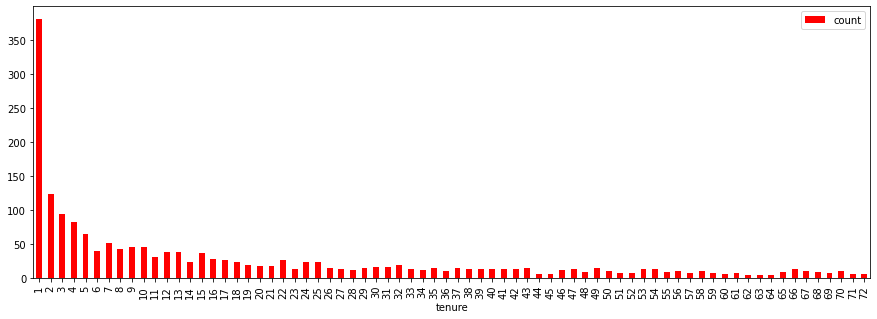

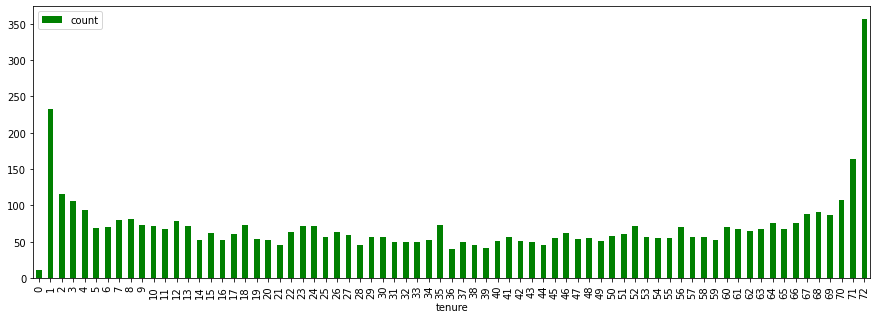

In [ ]:
# Analyze the numeric columns:
df.select("tenure", "TotalCharges", "MonthlyCharges").describe().show()

pdf_df = df.select("tenure", "churn").groupBy("tenure","churn").count()\
                                     .sort("tenure","churn").toPandas()
pdf_df[pdf_df["churn"] == "Yes"].plot.bar(x = "tenure", y = "count", 
                                          figsize = (15,5), color = "r")
pdf_df[pdf_df["churn"] == "No"].plot.bar(x = "tenure", y = "count", 
                                         figsize = (15,5), color = "g")

# We can see that the churn = yes rate drops with increasing tenure
# and subsequently that the churn = no rate increases with incr. tenure

## Create and run the pre-processing pipeline

In [ ]:
# Split data into train and test, with a seed of 24 -> ensures same split
(train_data, test_data) = df.randomSplit([0.7, 0.3], 24)
print("Records for trainig: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for trainig: 4942
Records for evaluation: 2101


In [ ]:
# Convert Categorical coloums into number using a string encoder and OHE
stages = []

for category in catColumns:
  stringIndexer = StringIndexer(inputCol = category, 
                                outputCol = category + "Index")
  OHE = OneHotEncoder(inputCol= stringIndexer.getOutputCol(), 
                      outputCol = category + "CatVec")
  stages += [stringIndexer, OHE]


In [ ]:
# Fix missing input -> as we saw there are some entries missing in TotalCharges.
# These inputs can be estimated using Linear regerssion -> use Imputer here
imputer = Imputer(inputCol= "TotalCharges", outputCol = "out_TotalCharges")
stages += [imputer]

In [ ]:
# Finally convert label -> churn YES/NO to 0/1 using a string indexer
label_Idx = StringIndexer(inputCol = "Churn", outputCol = "label")
stages += [label_Idx]

In [ ]:
# create feature Vector using VectorAssembler
numericCols = ["tenure", "out_TotalCharges", "MonthlyCharges"]
assembleInputs = [c + "CatVec" for c in catColumns] + numericCols
assembler = VectorAssembler(inputCols = assembleInputs, outputCol = "features")
stages += [assembler]

In [ ]:
# Final Stages summary:
stages

In [ ]:
# Create pipeline and run it on training data
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_data)

# Transform Training and Test Data -> Append new categorical and num columns
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

# Finally we the data preprocesssing is finished, the end-result is a 30-dim
# features vector and a numerical labels vector necesarry for training the LR
trainprepDF.printSchema()
trainprepDF.show(2)

## Create and Evaluate Model with HyperParameter Tuning


In [ ]:
# Use a Logistic Regression for predictions. By default the Model expects
# featuresCol = "features" and labelCol = 'label' as is the case here
lr = LogisticRegression()
evaluatorLR = BinaryClassificationEvaluator()

# Perform CrossValidation and look for the best parameter combination
# Create Parameter Grid for Cross Validation
paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(lr.maxIter, [5, 10, 15])
            .build())

# Use 5-Fold CrossValidation to test the parameter combinations
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator = evaluatorLR)
cvModel = cv.fit(trainprepDF)

Accuracy: 0.8095912585997572
FPR: 0.36212877484695083
TPR: 0.8095912585997571
F-Measure: 0.8026086438816719
Precision: 0.8006988491946883
Recall: 0.8095912585997571
AreaUnderRoc: 0.8521177267433027



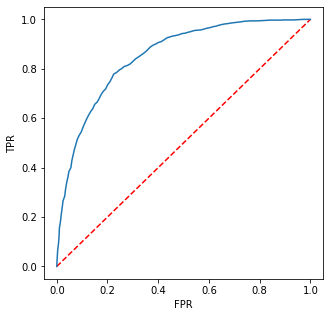

In [ ]:
# Analyze Logistic Regression Results for the Training Dataset
summary = cvModel.bestModel.summary
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
AreaUnderROC = summary.areaUnderROC

print(("Accuracy: %s\nFPR: %s\nTPR: %s\nF-Measure: %s\nPrecision: %s\nRecall: "
       "%s\nAreaUnderRoc: %s\n") % (accuracy, falsePositiveRate, 
                                    truePositiveRate, fMeasure, precision, 
                                    recall,AreaUnderROC))

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
# Evaluate Logistic Regression using the Testing Dataset
predictions = cvModel.bestModel.transform(testprepDF)
# The transform method appends 3 new columns to the DF using the LR data, 
# namely RawPred, Prob, Pred. Therefore it is also possible to add the LogReg 
# to the Pipeline!
evaluatorLR = BinaryClassificationEvaluator()
area_under_curve = evaluatorLR.evaluate(predictions)
print("Log. Reg. Test Performance: " + str(area_under_curve))

Log. Reg. Test Performance: 0.8288022920791268


## Test a Different Classifier

In [ ]:
rf = RandomForestClassifier()

paramGrid = (ParamGridBuilder()
            .addGrid(rf.impurity, ["gini", "entropy"])
            .addGrid(rf.numTrees, [20, 40, 60])
            .addGrid(rf.maxDepth, [5, 10, 15])
            .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                    evaluator = evaluatorLR)
cvModel = cv.fit(trainprepDF)

In [ ]:
# Evaluate Logistic Regression using the Testing Dataset
predictions = cvModel.bestModel.transform(testprepDF)
evaluatorLR = BinaryClassificationEvaluator()
area_under_curve = evaluatorLR.evaluate(predictions)
print("Random Forest Test Performance: " + str(area_under_curve))

Random Forest Test Performance: 0.8308372941141294
